## Setup

In [5]:
!pip install gurobipy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 40.4 MB/s eta 0:00:00


In [6]:
import gurobipy as gp
import pandas as pd
import numpy as np

In [7]:
#@title GUROBI full-use license set-up (Do not run if you don't want the full license)
# Setup the Gurobi environment with the WLS license
params = {
  "WLSACCESSID": '',
  "WLSSECRET": '',
  "LICENSEID": ,
}
env = gp.Env(params=params)

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2384086
Academic license - for non-commercial use only - registered to osthoag@stanford.edu


In [8]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [9]:
# https://drive.google.com/file/d/1AAKfl4XElbQJgC10QYWMOpInGqzWEs_x/view?usp=share_link
id='1AAKfl4XElbQJgC10QYWMOpInGqzWEs_x'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('family_data.csv')
# https://drive.google.com/file/d/11rYMZAFrDFzKqbNsXQO3qVumaGwYC4CJ/view?usp=sharing
id='11rYMZAFrDFzKqbNsXQO3qVumaGwYC4CJ'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('basic_MIP_model.sol')
# https://drive.google.com/file/d/172cchMjCrtVNfe_P5jr9UtvTI8baSb04/view?usp=sharing
id='11rYMZAFrDFzKqbNsXQO3qVumaGwYC4CJ'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('neighborhood_search_20_thresh.sol')
# https://drive.google.com/file/d/1zZeG9njfQd31crckQjaEmLn5mgY9fYXx/view?usp=sharing
id='1zZeG9njfQd31crckQjaEmLn5mgY9fYXx'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('neighborhood_search_70_thresh.sol')
# https://drive.google.com/file/d/11auk-ynyuFRhk2xQwMyVqTlN-wfnns56/view?usp=share_link
id='11auk-ynyuFRhk2xQwMyVqTlN-wfnns56'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('neighborhood_search_100_thresh.sol')
# https://drive.google.com/file/d/1hQXWwTOSL5DG2RKGq6ecM23acIbSS_wK/view?usp=share_link
id='1hQXWwTOSL5DG2RKGq6ecM23acIbSS_wK'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('neighborhood_search_120_thresh.sol')
# https://drive.google.com/file/d/1aQ6zucp_gyfSBw8InNDDFu0EKuje-dSK/view?usp=sharing
id='1aQ6zucp_gyfSBw8InNDDFu0EKuje-dSK'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('overflow_ga.npy')
# https://drive.google.com/file/d/19QeTIl7IZvEG7fW9JYu5hFEYh0iG6GdM/view?usp=share_link
id='19QeTIl7IZvEG7fW9JYu5hFEYh0iG6GdM'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('x_ga.npy')
# https://drive.google.com/file/d/1X-uh8NXNWjL0Umo-Crg__ZLrnMCst0Oy/view?usp=share_link
id='1X-uh8NXNWjL0Umo-Crg__ZLrnMCst0Oy'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('y_ga.npy')
# https://drive.google.com/file/d/1dcRxGCYN6tTC0k0GpsDG7XD7OqtORvTu/view?usp=share_link
id='1dcRxGCYN6tTC0k0GpsDG7XD7OqtORvTu'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('overflow_sa.npy')
# https://drive.google.com/file/d/1pHyTDMVkyZmB59E6VDvE0e2bUIW8p9-y/view?usp=share_link
id='1pHyTDMVkyZmB59E6VDvE0e2bUIW8p9-y'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('x_sa.npy')
# https://drive.google.com/file/d/19a2BoPN23MJEzmJP9Up-jjzgjmMaXC3a/view?usp=share_link
id='19a2BoPN23MJEzmJP9Up-jjzgjmMaXC3a'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('y_sa.npy')

# Run Single Formulation

### Load data

In [ ]:
family_data = pd.read_csv("family_data.csv")
n_fam = len(family_data.index)
n_pref = 11
n_days = 100
max_vis = 300
min_vis = 125
n_vis = max_vis - min_vis + 1
n_ppl = family_data["n_people"].sum()
fam_size = family_data["n_people"].to_numpy()
pref = family_data.filter(like="choice").to_numpy() - 1

In [ ]:
def preference_cost(p, s):
    # p=10 if the assigned preference is 10 or larger
    fixed_costs = [0, 50, 50, 100, 200, 200, 300, 300, 400, 500, 500]
    marginal_costs = [0, 0, 9, 9, 9, 18, 18, 36, 36, 235, 434]
    return fixed_costs[p] + s*marginal_costs[p]

P = np.ones((n_fam,n_days)) # initialize matrix
for f in range(n_fam):
    P[f,:] *= preference_cost(10,fam_size[f]) # scale row to worst case cost
    for p in range(n_pref-1):
        d = pref[f, p] # get day preference p
        P[f,d] = preference_cost(p,fam_size[f]) # update cost matrix

PC = np.array([[preference_cost(p, fam_size[f]) for p in range(n_pref)] for f in range(n_fam)])

def accounting_cost(n_d, n_dplus1):
    return ((n_d-125)/400)*n_d**(1/2+abs(n_d-n_dplus1)/50)

AC = np.ones((n_vis,n_vis)) # initialize matrix
for i in range(n_vis):
    for j in range(n_vis):
        AC[i,j] = accounting_cost(i+125,j+125) # update cost matrix

def get_day(f, p):
    return family_data.loc[f, "choice_"+str(p)]

def get_overflow_day(f, pbar):
    preferences = family_data.loc[f].filter(like="choice").to_numpy()
    overflow_days = np.array([[i for i in range(1, n_days+1) if i not in preferences]])
    return overflow_days[pbar]
  
def read_solution(file):
    # One-hot encoded versions of the decision variables
    x = np.zeros((n_fam, n_pref)).astype(int)
    z = np.zeros(n_days).astype(int)
    y = np.zeros((n_days, n_vis, n_vis)).astype(int)
    overflow = np.zeros((n_fam, n_days - 10)).astype(int)
    assignment = np.zeros(n_fam)

    with open(file, "r") as f:
        f.readline()
        for line in f:
            coef, value = line.split("] ")
            value = int(np.round(float(value)))
            variable, indices = coef.split("[")
            if variable != "z":
                if variable != "y":
                    index1, index2 = map(lambda x: int(x), indices.split(","))
                    if variable == "x" and value:
                        if assignment[index1] != 0:
                            raise RuntimeError("Infeasible")
                        x[index1, index2] = 1
                        if index2 <= 9:
                            assignment[index1] = get_day(index1, index2)
                    if variable == "overflow" and value:
                        if assignment[index1] != 0:
                            raise RuntimeError("Infeasible")
                        overflow[index1, index2] = 1
                        if index2 <= 9:
                            assignment[index1] = get_overflow_day(index1, index2)
                else:
                    if value:
                        index1, index2, index3 = map(lambda x: int(x), indices.split(","))
                        y[index1, index2, index3] = 1
            else:
                index = int(indices)
                z[index] = value
    return x,y,z,overflow,assignment

def get_x_z_assignment(pref_assignments):
    x = np.zeros((n_fam, n_pref)).astype(int)
    assignment = np.zeros(n_fam)
    for f in range(n_fam):
        d = pref[f,pref_assignments[f]]
        x[f,d] = 1
        assignment[f] = d
    z = fam_size.T @ x
    return x, z, assignment

## Create neighborhood

In [ ]:
x_init,y_init,z_init,overflow_init,assignment_init = read_solution("basic_MIP_model.sol")
# Preference cost
pref_cost_init = sum(x_init[f, p]*preference_cost(p, fam_size[f]) for f in range(n_fam) for p in range(n_pref))
# Accounting cost
acc_cost_init = sum(y_init[d, i, j]*accounting_cost(i+125,j+125) for d in range(n_days) for i in range(n_vis) for j in range(n_vis))
print(pref_cost_init)
print(acc_cost_init)
pref_cost_init + acc_cost_init

63917
5424.4315208417665


69341.43152084177

In [ ]:
AC_thresh = 25703
TR = 20
l = np.array([fam_size @ (assignment_init == d+1) for d in range(n_days)]).flatten()

In [ ]:
d_feas = {}
y_feas = []
for d in range(n_days):
    d_feas[d] = []
    lb_i = max(int(l[d])-TR-125, 0)
    ub_i = min(int(l[d])+TR-125+1, n_vis)
    for i in range(lb_i, ub_i):
        if d < n_days-1:
            lb_j = max(int(l[d+1])-TR-125, 0)
            ub_j = min(int(l[d+1])+TR-125+1, n_vis)
            for j in range(lb_j, ub_j):
                if AC[i,j] <= AC_thresh:
                    y_feas.append((d,i,j))
        else:
            if AC[i,j] <= AC_thresh:
                y_feas.append((d,i,i))
        d_feas[d].append(i)

# y_feas = [(d, i, j) for d in range(nb_days-1) for i in range(max(int(l[d])-TR-125, 0), min(int(l[d])+TR-125+1, nb_possible_crowd)) for j in range(max(int(l[d+1])-TR-125, 0), min(int(l[d+1])+TR-125+1, nb_possible_crowd)) if accounting_cost(i+125,j+125)<ac_thresh]
# y_feas += [(99, i, i) for i in range(max(int(l[99])-TR-125, 0), min(int(l[99])+TR-125+1, nb_possible_crowd)) if accounting_cost(i+125,i+125)<ac_thresh]

## Define Model

In [ ]:
model = gp.Model(env=env)

# Define the decision variables: x[f,p]: matching of family with preference number
x = model.addVars(n_fam, n_pref, vtype=gp.GRB.BINARY, name="x")

# z[d]: number of people allocated to day d
z = model.addVars(n_days, lb=125, ub=300, vtype=gp.GRB.CONTINUOUS, name="z")

# y[d, i, j]: number of people allocated do day d and to day d+1 (previous day), one-hot encoded in [125,350]
y = {}
for (d,i,j) in y_feas:
    y[d,i,j] = model.addVar(vtype=gp.GRB.BINARY, name=f"y[{d},{i},{j}]")

In [ ]:
# Define the objective function
# Preference cost
pref_cost = gp.quicksum(PC[f, p] * x[f, p] for p in range(n_pref) for f in range(n_fam))

# Accounting cost
acc_cost = gp.quicksum(AC[i,j] * y[d,i,j] for (d,i,j) in y_feas)

model.setObjective(pref_cost + acc_cost, gp.GRB.MINIMIZE)

In [ ]:
# Ensure that each family is matched to only one preference and one day if assigned to no preference
model.addConstrs(gp.quicksum(x[f,p] for p in range(n_pref)) == 1 for f in range(n_fam)) #2

# Ensure that there is only one coefficient of y equal to 1 for each day (only a single number of people allocated to day d and day d+1)
model.addConstrs(gp.quicksum(y[d,i,j] for (d,i,j) in y_feas if d == day)==1 for day in range(n_days)) #3

# Ensure that the values in y are consistent with each other for each pair of two contiguous days
model.addConstrs(gp.quicksum(y[d,i,j] for (d,i,j) in y_feas if d == day and j == n) == gp.quicksum(y[d,i,j] for (d,i,j) in y_feas if d == day+1 and i == n) for day in range(n_days-1) for n in d_feas[day+1]) #4

# Ensure that the sum of y matches the number of people assigned to that day
model.addConstrs(gp.quicksum((i+125)*y[d,i,j] for (d,i,j) in y_feas if d == day) == z[day] for day in range(n_days)) #5

# Ensure that the number of people assigned on each day based on preferences doesn't exceed the value contained in y (it's an inequality because of the possibility of assigning to the last priority and thus to any day)
model.addConstrs(gp.quicksum(fam_size[f]*x[f,p] for f in range(n_fam) for p in np.where(pref[f,:] == d)[0]) <= z[d] for d in range(n_days)) #6

# Ensure that the sum of z matches the total number of people
model.addConstr(gp.quicksum(z[d] for d in range(n_days)) == n_ppl) #7

# Limit the accounting cost that can be incurred
model.addConstr(acc_cost <= AC_thresh) #9

<gurobi.Constr *Awaiting Model Update*>

In [ ]:
# Save intermediary solutions
model.setParam('OutputFlag', 1)
model.setParam('ResultFile', f'neighborhood_search_{TR}_tresh.sol')
model.optimize()

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Academic license - for non-commercial use only - registered to osthoag@stanford.edu
Optimize a model with 8677 rows, 171730 columns and 687067 nonzeros
Model fingerprint: 0x806c3118
Variable types: 100 continuous, 171630 integer (171630 binary)
Coefficient statistics:
  Matrix range     [3e-02, 3e+04]
  Objective range  [3e-02, 3e+04]
  Bounds range     [1e+00, 3e+02]
  RHS range        [1e+00, 3e+04]
Presolve removed 71 rows and 2392 columns
Presolve time: 2.29s
Presolved: 8606 rows, 169338 columns, 665776 nonzeros
Variable types: 0 continuous, 169338 integer (169240 binary)

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   26104    6.8197140e+04   1.154335e+03   0.000000e+00      5s
   34439    6.8959161e+04   0.000000e+00   0.000000e+00

## Check solution

In [ ]:
x_star,y_star,z_star,overflow_star,assignment_star = read_solution("neighborhood_search_model.sol")
# Preference cost
pref_cost_orig = sum(x_star[f, p]*preference_cost(p, fam_size[f]) for f in range(n_fam) for p in range(n_pref))
# Accounting cost
acc_cost_orig = sum(y_star[d, i, j]*accounting_cost(i+125,j+125) for d in range(n_days) for i in range(n_vis) for j in range(n_vis))
print(pref_cost_orig)
print(acc_cost_orig)
pref_cost_orig + acc_cost_orig

63601
5527.989503168564


69128.98950316856

In [ ]:
pref_cost_revised = sum(P[f, int(assignment_star[f]-1)] for f in range(n_fam))
print(pref_cost_revised)

acc_cost_revised = sum([accounting_cost(z_star[d], z_star[min(d+1, n_days-1)]) for d in range(n_days)])
print(acc_cost_revised)

print(pref_cost_revised + acc_cost_revised)

63601.0
5527.989503168564
69128.98950316856


In [ ]:
for d in range(n_days):
    if np.sum(y_star[d,:,:]) != 1:
        print(np.sum(y_star[d,:,:]))
        print(d)
        raise Exception("problem with encoding of y")

In [ ]:
for d in range(n_days-1):
    for n in range(n_vis):
        if np.sum(y_star[d+1,n,:]) != np.sum(y_star[d,:,n]):
            print(d)
            print(n)
            print(np.where(y_star[d+1,n,:]))
            print(np.where(y_star[d,:,n]))
            raise Exception("problem with continuity of y")

In [ ]:
all_vars = model.getVars()
values = model.getAttr("X", all_vars)
names = model.getAttr("VarName", all_vars)
vars = dict(zip(names, values))

## Write solution

In [ ]:
results_dict = {"family_id": range(n_fam), "assigned_day": assignment_star.astype(int)}
results_df = pd.DataFrame(results_dict)
results_df.to_csv("neighborhood_search_submission_2.csv", index=False)

# Run Any Formulation

**Need to run "setup" cells first**

### Load Data

In [10]:
family_data = pd.read_csv("family_data.csv")
n_fam = len(family_data.index)
n_pref = 11
n_days = 100
max_vis = 300
min_vis = 125
n_vis = max_vis - min_vis + 1
n_ppl = family_data["n_people"].sum()
fam_size = family_data["n_people"].to_numpy()
pref = family_data.filter(like="choice").to_numpy() - 1

In [11]:
def preference_cost(p, s):
    # p=10 if the assigned preference is 10 or larger
    fixed_costs = [0, 50, 50, 100, 200, 200, 300, 300, 400, 500, 500]
    marginal_costs = [0, 0, 9, 9, 9, 18, 18, 36, 36, 235, 434]
    return fixed_costs[p] + s*marginal_costs[p]

P = np.ones((n_fam,n_days)) # initialize matrix
for f in range(n_fam):
    P[f,:] *= preference_cost(10,fam_size[f]) # scale row to worst case cost
    for p in range(n_pref-1):
        d = pref[f, p] # get day preference p
        P[f,d] = preference_cost(p,fam_size[f]) # update cost matrix

PC = np.array([[preference_cost(p, fam_size[f]) for p in range(n_pref)] for f in range(n_fam)])

def accounting_cost(n_d, n_dplus1):
    return ((n_d-125)/400)*n_d**(1/2+abs(n_d-n_dplus1)/50)

AC = np.ones((n_vis,n_vis)) # initialize matrix
for i in range(n_vis):
    for j in range(n_vis):
        AC[i,j] = accounting_cost(i+125,j+125) # update cost matrix

def get_day(f, p):
    return family_data.loc[f, "choice_"+str(p)]

def get_overflow_day(f, pbar):
    preferences = family_data.loc[f].filter(like="choice").to_numpy()
    overflow_days = np.array([[i for i in range(1, n_days+1) if i not in preferences]])
    return overflow_days[pbar]
  
def read_solution(file):
    # One-hot encoded versions of the decision variables
    x = np.zeros((n_fam, n_pref)).astype(int)
    z = np.zeros(n_days).astype(int)
    y = np.zeros((n_days, n_vis, n_vis)).astype(int)
    overflow = np.zeros((n_fam, n_days - 10)).astype(int)
    assignment = np.zeros(n_fam)

    with open(file, "r") as f:
        f.readline()
        for line in f:
            coef, value = line.split("] ")
            value = int(np.round(float(value)))
            variable, indices = coef.split("[")
            if variable != "z":
                if variable != "y":
                    index1, index2 = map(lambda x: int(x), indices.split(","))
                    if variable == "x" and value:
                        if assignment[index1] != 0:
                            raise RuntimeError("Infeasible")
                        x[index1, index2] = 1
                        if index2 <= 9:
                            assignment[index1] = get_day(index1, index2)
                    if variable == "overflow" and value:
                        if assignment[index1] != 0:
                            raise RuntimeError("Infeasible")
                        overflow[index1, index2] = 1
                        if index2 <= 9:
                            assignment[index1] = get_overflow_day(index1, index2)
                else:
                    if value:
                        index1, index2, index3 = map(lambda x: int(x), indices.split(","))
                        y[index1, index2, index3] = 1
            else:
                index = int(indices)
                z[index] = value
    return x,y,z,overflow,assignment

def get_x_z_assignment(pref_assignments):
    x = np.zeros((n_fam, n_pref)).astype(int)
    z = np.zeros(n_days)
    assignment = np.zeros(n_fam)
    for f in range(n_fam):
        p = int(pref_assignments[f])
        x[f,p] = 1
        d = pref[f,p]
        z[d] += fam_size[f]
        assignment[f] = d
    return x, z, assignment

In [12]:
AC_thresh = 69319 - 43622
basic_solution_file = "basic_MIP_model.sol"
x_basic,y_basic,z_basic,overflow_basic,assignment_basic = read_solution(basic_solution_file)
ns_20_file = "neighborhood_search_20_thresh.sol"
x_20,y_20,z_20,overflow_20,assignment_20 = read_solution(ns_20_file)
ns_70_file = "neighborhood_search_70_thresh.sol"
x_70,y_70,z_70,overflow_70,assignment_70 = read_solution(ns_70_file)
ns_100_file = "neighborhood_search_100_thresh.sol"
x_100,y_100,z_100,overflow_100,assignment_100 = read_solution(ns_100_file)
ns_120_file = "neighborhood_search_120_thresh.sol"
x_120,y_120,z_120,overflow_120,assignment_120 = read_solution(ns_120_file)

In [13]:
z_basic = np.array([fam_size @ (assignment_basic == d+1) for d in range(n_days)]).flatten()
z_20 = np.array([fam_size @ (assignment_20 == d+1) for d in range(n_days)]).flatten()

In [14]:
pref_assignments_ga = np.load('x_ga.npy')
y_ga = np.load('y_ga.npy')
overflow_ga = np.load('overflow_ga.npy')
x_ga, z_ga, assignment_ga = get_x_z_assignment(pref_assignments_ga)
pref_assignments_sa = np.load('x_sa.npy')
y_sa = np.load('y_sa.npy')
overflow_sa = np.load('overflow_sa.npy')
x_sa, z_sa, assignment_sa = get_x_z_assignment(pref_assignments_sa)

## Plots

### Plot the Solutions

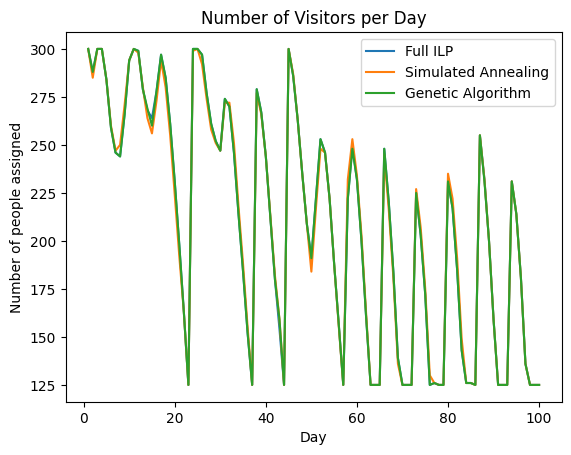

In [ ]:
days = np.arange(1, 101)
plt.plot(days, z_basic, label = "Full ILP")
plt.plot(days, z_sa, label = "Simulated Annealing")
plt.plot(days, z_ga, label = "Genetic Algorithm")
plt.xlabel("Day")
plt.ylabel("Number of people assigned")
plt.title("Number of Visitors per Day")
plt.legend()
plt.show()

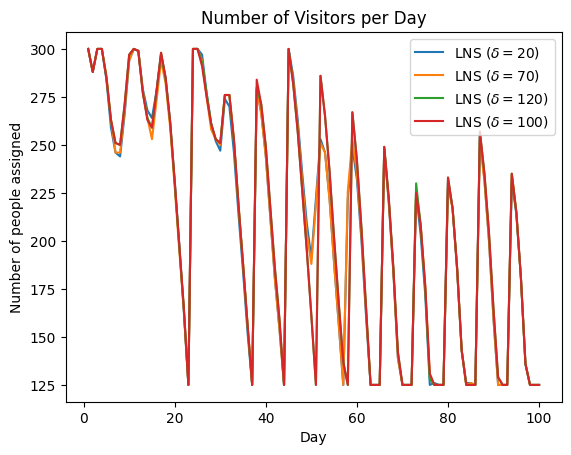

In [ ]:
days = np.arange(1, 101)
plt.plot(days, z_20, label = "LNS ($\delta = 20$)")
plt.plot(days, z_70, label = "LNS ($\delta = 70$)")
plt.plot(days, z_120, label = "LNS ($\delta = 120$)")
plt.plot(days, z_100, label = "LNS ($\delta = 100$)")
plt.xlabel("Day")
plt.ylabel("Number of people assigned")
plt.title("Number of Visitors per Day")
plt.legend()
plt.show()

In [15]:
def accounting_cost(n_d, n_dplus1):
    return ((n_d-125)/400)*n_d**(1/2+abs(n_d-n_dplus1)/50)

n_d_100 = z_100
n_dplus1_100 = np.roll(z_100, -1)
n_dplus1_100[-1] = n_d_100[-1]
accounting_costs_100 = accounting_cost(n_d_100, n_dplus1_100)
max_AC = 50 * round(accounting_costs_100.max()/50)
max_AC

250

<ipython-input-16-8cf1a20ab976>:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.set_ticklabels(ticks)


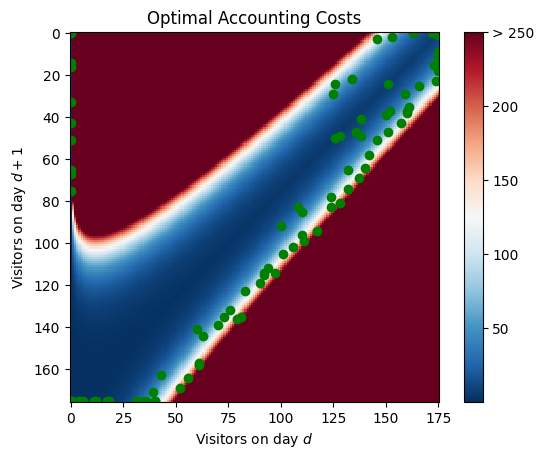

In [16]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np

# Define the range of values for n_d and n_dplus1

n_d_values = np.arange(125, 301)
n_dplus1_values = np.flip(np.arange(125, 301))

# Create a grid of values for n_d and n_dplus1
n_d_grid, n_dplus1_grid = np.meshgrid(n_d_values, n_dplus1_values)

# Calculate the accounting cost for each combination of n_d and n_dplus1
costs = accounting_cost(n_d_grid, n_dplus1_grid)

# Create a figure and axes
fig, ax = plt.subplots()

# Create the heatmap
norm = colors.Normalize(vmin=0.01, vmax=max_AC)
heatmap = ax.imshow(costs, cmap='RdBu_r', interpolation='nearest', norm=norm)

# Remove the axis ticks and labels
# ax.set_xticks([])
# ax.set_yticks([])

# Add a colorbar
cbar = fig.colorbar(heatmap)
ticks = cbar.get_ticks().astype(int).astype(str)
ticks[5] = f"> {max_AC}"
cbar.set_ticklabels(ticks)

# Plot Solution
ax.scatter(n_d_100-min_vis, max_vis-n_dplus1_100, color = "green")

# Set the title
ax.set_title('Optimal Accounting Costs')
ax.set_xlabel('Visitors on day $d$')
ax.set_ylabel('Visitors on day $d+1$')

# Show the plot
plt.show()

In [ ]:
pref_assignments_100 = np.argmax(x_100,axis=1)
pref_costs_100 = [P[f,int(assignment_100[f])-1] for f in range(n_fam)]
# plt.scatter(fam_size, pref_assignments_100)
# plt.show()

fam_sizes = np.unique(fam_size)
prefs = np.unique(pref_assignments_100)
sum(pref_costs_100)

62877.0

In [ ]:
pref0 = [np.sum(np.where(np.logical_and(fam_size == s, pref_assignments_100 == 0), 1, 0)) for s in fam_sizes]
pref1 = [np.sum(np.where(np.logical_and(fam_size == s, pref_assignments_100 == 1), 1, 0)) for s in fam_sizes]
pref2 = [np.sum(np.where(np.logical_and(fam_size == s, pref_assignments_100 == 2), 1, 0)) for s in fam_sizes]
pref3 = [np.sum(np.where(np.logical_and(fam_size == s, pref_assignments_100 == 3), 1, 0)) for s in fam_sizes]
pref4 = [np.sum(np.where(np.logical_and(fam_size == s, pref_assignments_100 == 4), 1, 0)) for s in fam_sizes]

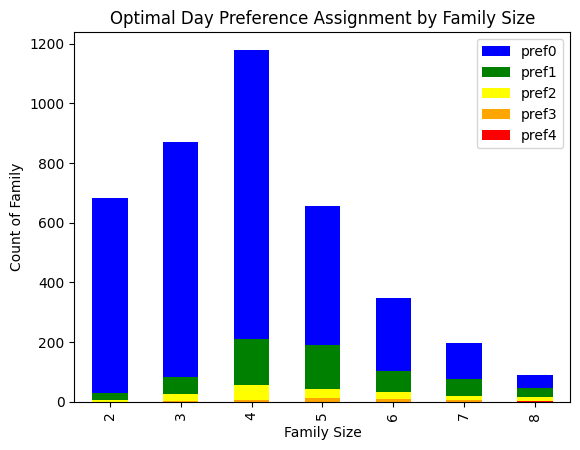

In [ ]:
# importing pandas library
import pandas as pd
# import matplotlib library
import matplotlib.pyplot as plt

# creating dataframe
df = pd.DataFrame({
    'fam_sizes': fam_sizes,
    'pref0': pref0,
    'pref1': pref1,
    'pref2': pref2,
    'pref3': pref3,
    'pref4': pref4,
})
  
ax = df.plot(x="fam_sizes", y="pref0", kind="bar", color = "blue")
df.plot(x="fam_sizes", y="pref1", kind="bar", ax=ax, color = "green")
df.plot(x="fam_sizes", y="pref2", kind="bar", ax=ax, color = "yellow")
df.plot(x="fam_sizes", y="pref3", kind="bar", ax=ax, color = "orange")
df.plot(x="fam_sizes", y="pref4", kind="bar", ax=ax, color = "red")
plt.xlabel("Family Size")
plt.ylabel("Count of Family")
plt.title("Optimal Day Preference Assignment by Family Size")
plt.show()

### Plot the Neighborhood Search Space

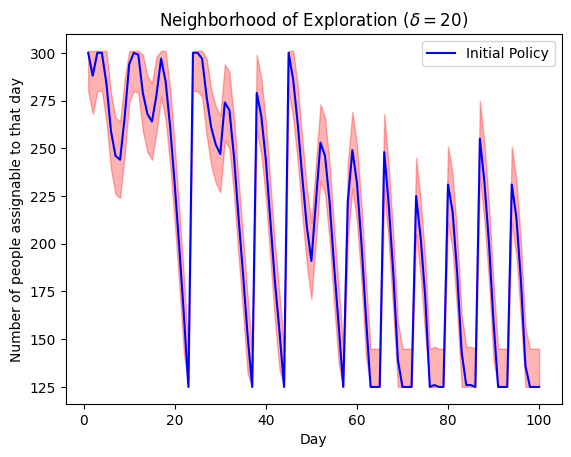

In [17]:
TR = 20
neighborhood_UB = np.minimum(z_basic + TR, max_vis + 1)
neighborhood_LB = np.maximum(z_basic - TR, min_vis)
days = np.arange(1, 101)
plt.plot(days, z_basic, label="Initial Policy", color="blue")
# plt.plot(days, neighborhood_UB, label=f"$\delta = +{TR}$", color="red")
# plt.plot(days, neighborhood_LB, label=f"$\delta = -{TR}$", color="red")

# Shade the region between the two red lines
plt.fill_between(days, neighborhood_UB, neighborhood_LB, color='red', alpha=0.3)

plt.xlabel("Day")
plt.ylabel("Number of people assignable to that day")
plt.title(f"Neighborhood of Exploration ($\delta = {TR}$)")
plt.legend()
plt.show()

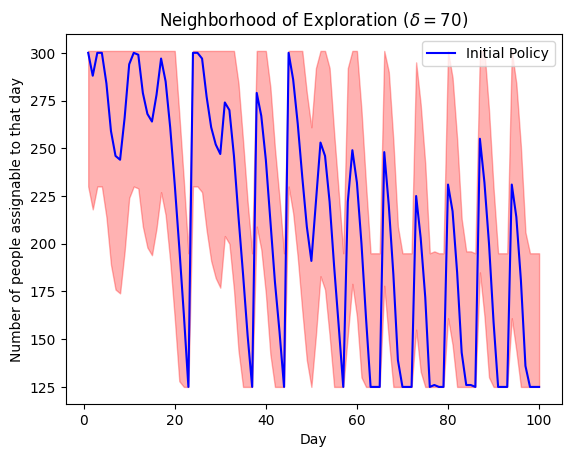

In [18]:
TR = 70
neighborhood_UB = np.minimum(z_basic + TR, max_vis + 1)
neighborhood_LB = np.maximum(z_basic - TR, min_vis)
days = np.arange(1, 101)
plt.plot(days, z_basic, label="Initial Policy", color="blue")
# plt.plot(days, neighborhood_UB, label=f"$\delta = +{TR}$", color="red")
# plt.plot(days, neighborhood_LB, label=f"$\delta = -{TR}$", color="red")

# Shade the region between the two red lines
plt.fill_between(days, neighborhood_UB, neighborhood_LB, color='red', alpha=0.3)

plt.xlabel("Day")
plt.ylabel("Number of people assignable to that day")
plt.title(f"Neighborhood of Exploration ($\delta = {TR}$)")
plt.legend()
plt.show()

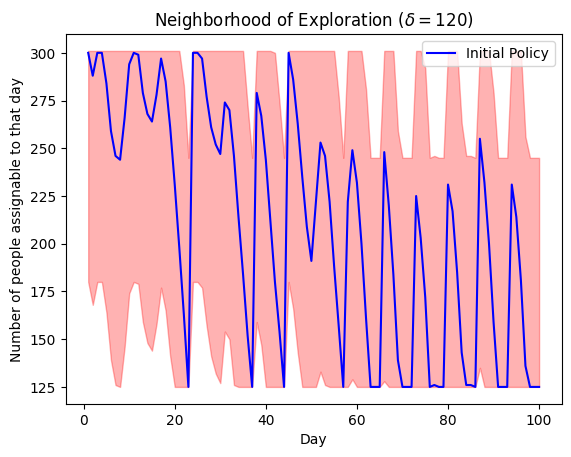

In [19]:
TR = 120
neighborhood_UB = np.minimum(z_basic + TR, max_vis + 1)
neighborhood_LB = np.maximum(z_basic - TR, min_vis)
days = np.arange(1, 101)
plt.plot(days, z_basic, label="Initial Policy", color="blue")
# plt.plot(days, neighborhood_UB, label=f"$\delta = +{TR}$", color="red")
# plt.plot(days, neighborhood_LB, label=f"$\delta = -{TR}$", color="red")

# Shade the region between the two red lines
plt.fill_between(days, neighborhood_UB, neighborhood_LB, color='red', alpha=0.3)

plt.xlabel("Day")
plt.ylabel("Number of people assignable to that day")
plt.title(f"Neighborhood of Exploration ($\delta = {TR}$)")
plt.legend()
plt.show()

<ipython-input-21-13c7945eb0fe>:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.set_ticklabels(ticks)


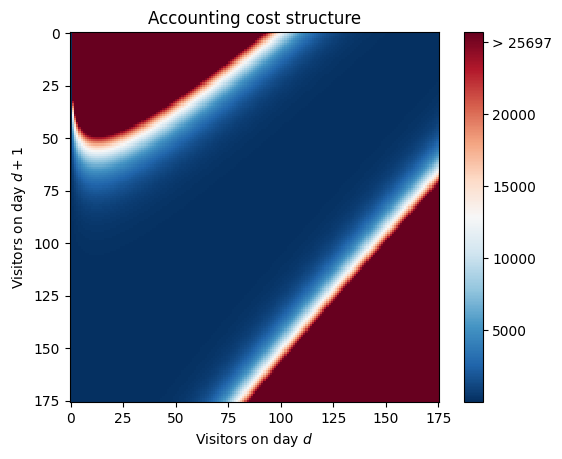

In [21]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np

AC_thresh = 69319 - 43622

def accounting_cost(n_d, n_dplus1):
    return ((n_d-125)/400)*n_d**(1/2+abs(n_d-n_dplus1)/50)
# Define the range of values for n_d and n_dplus1

n_d_values = np.arange(125, 301)
n_dplus1_values = np.flip(np.arange(125, 301))

# Create a grid of values for n_d and n_dplus1
n_d_grid, n_dplus1_grid = np.meshgrid(n_d_values, n_dplus1_values)

# Calculate the accounting cost for each combination of n_d and n_dplus1
costs = accounting_cost(n_d_grid, n_dplus1_grid)

# Create a figure and axes
fig, ax = plt.subplots()

# Create the heatmap
norm = colors.Normalize(vmin=0.01, vmax=AC_thresh)
heatmap = ax.imshow(costs, cmap='RdBu_r', interpolation='nearest', norm=norm)

# Remove the axis ticks and labels
# ax.set_xticks(range(min_vis, max_vis+1, 25))
ax.set_yticks(range(0,176,25))

# Add a colorbar
cbar = fig.colorbar(heatmap)
ticks = cbar.get_ticks().astype(int).astype(str)
ticks[5] = f"> {AC_thresh}"
cbar.set_ticklabels(ticks)

# Set the title
ax.set_title('Accounting cost structure')
ax.set_xlabel('Visitors on day $d$')
ax.set_ylabel('Visitors on day $d+1$')

# Show the plot
plt.show()

### Plot optimization results for different thresholds

In [26]:
size_of_y = [len(get_neighborhood(assignment_ga, TR, AC_thresh)[0]) for TR in range(n_vis)]

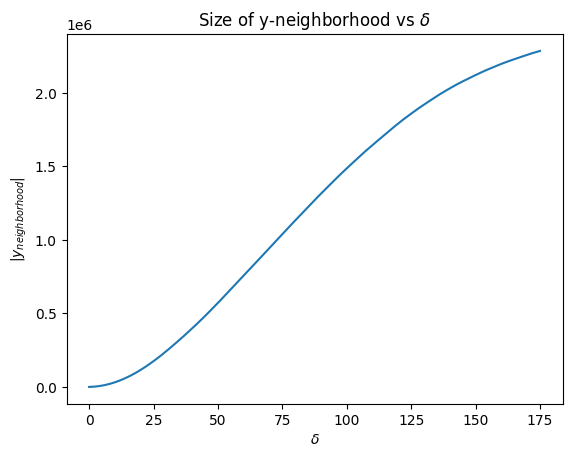

In [27]:
import matplotlib.pyplot as plt

plt.plot(np.arange(n_vis), size_of_y)
plt.title("Size of y-neighborhood vs $\delta$")
plt.xlabel("$\delta$")
plt.ylabel("$|y_{neighborhood}|$")
plt.show()

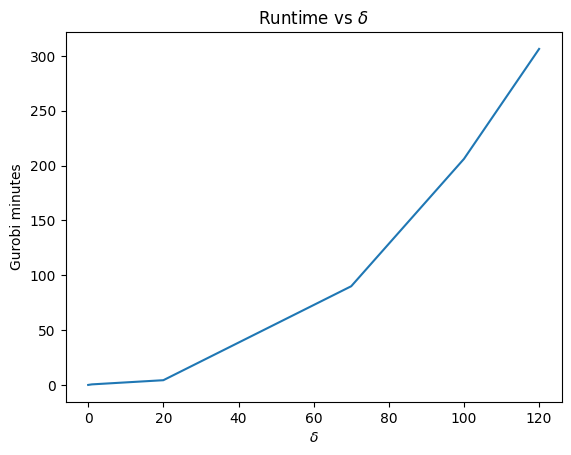

In [28]:
x = [0, 1, 20, 70, 100, 120]
y = [0, .5, 4.3, 90, 206.1, 306.4]
plt.plot(x, y)
plt.title("Runtime vs $\delta$")
plt.xlabel("$\delta$")
plt.ylabel("Gurobi minutes")
plt.show()

## Helper functions

In [23]:
def get_neighborhood(assignment_init, TR, AC_thresh):
    l = np.array([fam_size @ (assignment_init == d+1) for d in range(n_days)]).flatten()
    d_feas = {}
    y_feas = []
    for d in range(n_days):
        d_feas[d] = []
        lb_i = max(int(l[d])-TR-125, 0)
        ub_i = min(int(l[d])+TR-125+1, n_vis)
        for i in range(lb_i, ub_i):
            if d < n_days-1:
                lb_j = max(int(l[d+1])-TR-125, 0)
                ub_j = min(int(l[d+1])+TR-125+1, n_vis)
                for j in range(lb_j, ub_j):
                    if AC[i,j] <= AC_thresh:
                        y_feas.append((d,i,j))
            else:
                if AC[i,j] <= AC_thresh:
                    y_feas.append((d,i,i))
            d_feas[d].append(i)
    return y_feas, d_feas

In [24]:
def run_neighborhood_search(y_feas, d_feas, TR):
    model = gp.Model(env=env)
    x = model.addVars(n_fam, n_pref, vtype=gp.GRB.BINARY, name="x")
    z = model.addVars(n_days, lb=125, ub=300, vtype=gp.GRB.CONTINUOUS, name="z")
    y = {}
    for (d,i,j) in y_feas:
        y[d,i,j] = model.addVar(vtype=gp.GRB.BINARY, name=f"y[{d},{i},{j}]")
    pref_cost = gp.quicksum(PC[f, p] * x[f, p] for p in range(n_pref) for f in range(n_fam))
    acc_cost = gp.quicksum(AC[i,j] * y[d,i,j] for (d,i,j) in y_feas)
    model.setObjective(pref_cost + acc_cost, gp.GRB.MINIMIZE)
    model.addConstrs(gp.quicksum(x[f,p] for p in range(n_pref)) == 1 for f in range(n_fam)) #2
    model.addConstrs(gp.quicksum(y[d,i,j] for (d,i,j) in y_feas if d == day)==1 for day in range(n_days)) #3
    model.addConstrs(gp.quicksum(y[d,i,j] for (d,i,j) in y_feas if d == day and j == n) == gp.quicksum(y[d,i,j] for (d,i,j) in y_feas if d == day+1 and i == n) for day in range(n_days-1) for n in d_feas[day+1]) #4
    model.addConstrs(gp.quicksum((i+125)*y[d,i,j] for (d,i,j) in y_feas if d == day) == z[day] for day in range(n_days)) #5
    model.addConstrs(gp.quicksum(fam_size[f]*x[f,p] for f in range(n_fam) for p in np.where(pref[f,:] == d)[0]) <= z[d] for d in range(n_days)) #6
    model.addConstr(gp.quicksum(z[d] for d in range(n_days)) == n_ppl) #7
    model.addConstr(acc_cost <= AC_thresh) #9
    model.setParam('OutputFlag', 1)
    solution_file = f'neighborhood_search_{TR}_thres.sol'
    model.setParam('ResultFile', solution_file)
    model.optimize()
    return solution_file

In [25]:
from google.colab import files

def save_solution(solution_file, TR):
    files.download(solution_file)
    x_star,y_star,z_star,overflow_star,assignment_star = read_solution(solution_file)
    results_dict = {"family_id": range(n_fam), "assigned_day": assignment_star.astype(int)}
    results_df = pd.DataFrame(results_dict)
    submission_file = f'submission_{TR}_thres.csv'
    results_df.to_csv(submission_file, index=False)
    files.download(submission_file)

## Run formulation

In [ ]:
AC_thresh = 69319 - 43622
TR = 100
y_feas, d_feas = get_neighborhood(assignment_basic, TR, AC_thresh)
solution_file = run_neighborhood_search(y_feas, d_feas, TR)
save_solution(solution_file, TR)

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Academic license - for non-commercial use only - registered to osthoag@stanford.edu
Optimize a model with 18538 rows, 1556326 columns and 7594087 nonzeros
Model fingerprint: 0x77b19dbd
Variable types: 100 continuous, 1556226 integer (1556226 binary)
Coefficient statistics:
  Matrix range     [3e-02, 3e+04]
  Objective range  [3e-02, 3e+04]
  Bounds range     [1e+00, 3e+02]
  RHS range        [1e+00, 3e+04]
Presolve removed 0 rows and 0 columns (presolve time = 5s) ...
Presolve removed 1 rows and 220 columns (presolve time = 10s) ...
Presolve removed 1 rows and 359 columns (presolve time = 15s) ...
Presolve removed 1 rows and 359 columns (presolve time = 20s) ...
Presolve removed 1 rows and 359 columns (presolve time = 61s) ...
Presolve removed 1 rows and 359 columns
Presolve ti

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>